In [1]:
import sys
import os
import math
import glob
import numpy as np
import matplotlib.pyplot as plt

import PIL
from PIL import Image, ImageDraw, ImageFont

import openslide
from openslide import OpenSlideError, OpenSlideUnsupportedFormatError

import skimage.filters as sk_filters
from skimage import io, morphology, color

import cv2

In [5]:
BASE_DIR = os.path.join("/opt/imagia/data/", "datasets/public/Camelyon17/")
MASK_DIR = os.path.join(BASE_DIR, "masks/")
LEVEL = 8 # 0=highest resolution

## Visualize WSI

In [3]:
def open_slide(filename):
    """
    Create Openslide Object from a WSI (.svs, .tif, .ndpi, etc).
    
    Args:
        filename (str): Name of the slide file to open.
    
    Returns:
        An OpenSlide object representing a whole-slide image.
    """
    try:
        slide = openslide.open_slide(filename)
    except OpenSlideUnsupportedFormatError:
        slide = None
        print("Unrecognized file format.")
    except OpenSlideError:
        slide = None
        print("Slide file recognized. OpenSlide error.")
    except FileNotFoundError:
        slide = None
        print("Slide file not found.")
    return slide


def get_slide_info(filename):
    """
    Display information about the magnification levels in the WSI:
        - Level count: Number of different image resolutions available within the WSI.
        - Level dimensions: Pixel dimensions of the entire grid at a particular resolution level.
    
    Args:
        filename (str): Name of the slide file.
    """
    
    slide = openslide.open_slide(filename)
    level_count = slide.level_count
    level_dimensions = slide.level_dimensions
    print("Level count:         " + str(level_count))
    print("Level dimensions:    " + str(level_dimensions))
    return level_count, level_dimensions


def read_slide(slide, location, level, size, as_float=False):
    """
    Read a region of the WSI with Top Left corner at (x, y) at a certain resolution level
    
    Args:
        - slide     :    Openslide Object
        - location  :    (x, y) tuple giving the top left pixel in the level 0 reference frame
        - level     :    resolution level
        - size      :    (width, height) tuple giving the region size
    """
    img = slide.read_region(location, level, size)
    img = img.convert('RGB') # drop the alpha channel
    if as_float:
        img = np.asarray(img, dtype=np.float32)
    else:
        img = np.asarray(img)
    assert img.shape == (size[1], size[0], 3)
    return img


def display_slide(filename, level):
    """
    Display a scaled down version of a WSI.
    
    Args:
        - filename (str): name of the WSI to display.
        - level: resolution level
    """
    image_slide = open_slide(sample_slide)
    image = read_slide(image_slide, 
                       (0,0), 
                       level, 
                       (image_slide.level_dimensions[level][0], 
                        image_slide.level_dimensions[level][1]))

    plt.figure(figsize=(10, 10), dpi=100)
    plt.title("showing slide for: {}".format(os.path.splitext(os.path.basename(filename))[0]))
    plt.imshow(image)

sample slide file paths:  /opt/imagia/data/datasets/public/Camelyon17/training/center_0/patient_006_node_3.tif
Level count:         9
Level dimensions:    ((94968, 210579), (47484, 105289), (23742, 52644), (11871, 26322), (5935, 13161), (2967, 6580), (1483, 3290), (741, 1645), (370, 822))


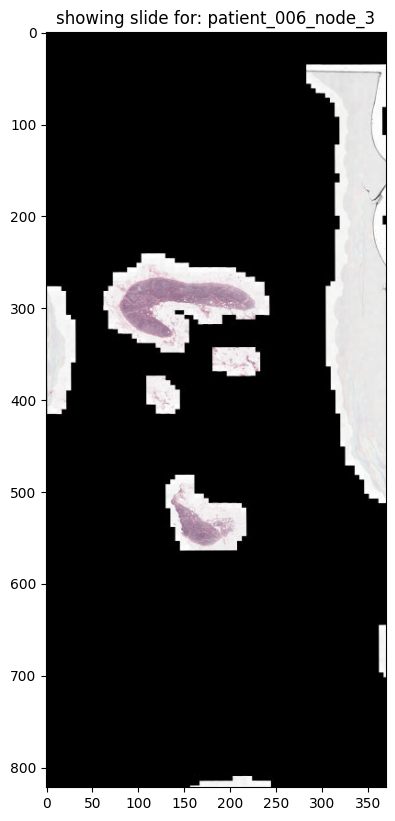

In [6]:
slides = glob.glob(BASE_DIR + 'training/center_*/patient_*.tif')
sample_slide = slides[0]
# sample_slide = os.path.join(BASE_DIR, 'training/center_0/patient_000_node_0.tif')
print("sample slide file paths: ", sample_slide)

level_count, level_dimensions = get_slide_info(sample_slide)
display_slide(sample_slide, LEVEL)

## Tissue - Background Segmentation in WSI

In [12]:
def slide_to_scaled_pil_image(filename):
    """
    Convert a WSI slide to a sclaed-down PIL image.
    
    Args:
        filename (str): Name of the slide file.
        
    Returns:
        Tuple of scaled-down PIL image, original width, original height, new width,
        and new height.
    """
    print("Opening slide {}".format(filename))
    slide = open_slide(filename)
    
    large_w, large_h = slide.dimensions
    new_w = math.floor(large_w / SCALE_FACTOR)
    new_h = math.floor(large_h / SCALE_FACTOR)
    level = slide.get_best_level_for_downsample(SCALE_FACTOR)
    whole_slide_image = slide.read_region((0, 0), level, slide.level_dimensions[level])
    whole_slide_image = whole_slide_image.convert("RGB")
    img = whole_slide_image.resize((new_w, new_h), PIL.Image.BILINEAR)
    return img, large_w, large_h, new_w, new_h


def training_slide_to_image(filename):
    """
    Convert a WSI slide to a saved scaled-down image in a format such as jpg or png.
    
    Args:
        filename (str): Name of the slide file.
    """
    img, large_w, large_h, new_w, new_h = slide_to_scaled_pil_image(filename)
    
    img_path = get_training_image_path(slide_number, large_w, large_h, new_w, new_h)
    print("Saving image to: ", img_path)
    if not os.path.exists(DEST_TRAIN_DIR):
        os.makedirs(DEST_TRAIN_DIR)
    img.save(img_path)


def pil_to_np_rgb(pil_img):
    """
    Convert a PIL Image to a NumPy array.
    Note that RGB PIL (w, h) -> NumPy (h, w, 3).
    
    Args:
        pil_img: The PIL Image.
    
    Returns:
        The PIL image converted to a NumPy array.
    """
    rgb = np.asarray(pil_img)
    return rgb

In [24]:
def filter_otsu_threshold(np_img, output_type="uint8"):
    """
    Compute Otsu threshold on image as a NumPy array and return binary image based on 
    pixels above threshold.
    
    Args:
        np_img: Image as a NumPy array.
        output_type: Type of array to return (bool, float, or uint8).
    
    Returns:
        NumPy array (bool, float, or uint8) where True, 1.0, and 255 represent a pixel 
        above Otsu threshold.
    """
    otsu_thresh_value = sk_filters.threshold_otsu(np_img)
    otsu = (np_img > otsu_thresh_value)
    if output_type == "bool":
        pass
    elif output_type == "float":
        otsu = otsu.astype(float)
    else:
        otsu = otsu.astype("uint8") * 255
    return otsu


def segment_tissue_from_background(slide, level):
    """
    Segment the Tissue foreground from the background through a series of transformation:
    RGB --> Remove black background pixels--> HSV --> Median Blurring -->
    Thresholding --> Morphological Operations to fill holes
    
    NOTE: In some of the CAMELYON17 cases, the Otsu’s thresholding failed because of the
    black regions in the WSI. So before the application of image thresholding operation,
    the black pixel regions in the WSI background are replaced with white pixels.
    
    Args:
        slide: Path to the slide to segment.

    Returns:
        cleaned: a ndarray (n=2) containing a binary Tissue mask.
    """
    image_slide = open_slide(slide)
    img = read_slide(image_slide, 
                       (0,0), 
                       level, 
                       (image_slide.level_dimensions[level][0], 
                        image_slide.level_dimensions[level][1])).copy()
    #remove black background in some WSI
    img[np.where((img==[0,0,0]).all(axis=2))] = [255,255,255]
    
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    img_med = cv2.medianBlur(img_hsv[:, :, 1], 7)

    otsu = filter_otsu_threshold(img_med)
    arr = otsu>0
#     cleaned = morphology.dilation(arr)
    cleaned = morphology.remove_small_objects(arr, min_size=4)
    cleaned = morphology.remove_small_holes(cleaned, area_threshold=16)
    cleaned = morphology.opening(cleaned, morphology.disk(4))
    return cleaned


def overlay_img_and_segmentation_mask(img, mask):
    """
    Display the segmentation mask on top of the image.
    
    Args:
        - img: Image to be segmented.
        - mask: Segmented mask of the Image.
    """
    # Construct RGB version of gray-level mask
    mask_color = np.dstack((mask, mask, mask))

    # Convert the input image and color mask to the HSV colorspace
    img_hsv = color.rgb2hsv(img)
    mask_hsv = color.rgb2hsv(mask_color)

    # Replace the hue and saturation of the original image with that of the color mask
    mask_hsv[..., 0] = img_hsv[..., 0]
    mask_hsv[..., 1] = img_hsv[..., 1] * alpha

    img_masked = color.hsv2rgb(mask_hsv)

    # Display the output
#     f, (ax0, ax1, ax2) = plt.subplots(1, 3,
#                                       figsize=(60, 60),
#                                       subplot_kw={'xticks':[], 'yticks':[]})
#     ax0.imshow(img, cmap=plt.cm.gray)
#     ax1.imshow(mask)
#     ax2.imshow(img_masked)

#     f, ax = plt.subplots(1, 1,
#                          figsize=(60, 60),
#                          subplot_kw={'xticks':[], 'yticks':[]})
#     ax.imshow(img_masked)
#     plt.savefig('segmented_img.png')
#     plt.show()
    return img_masked

In [14]:
alpha = 0.9
image_slide = open_slide(sample_slide)
img = read_slide(image_slide, (0,0), LEVEL, (image_slide.level_dimensions[LEVEL][0], image_slide.level_dimensions[LEVEL][1]))
mask = segment_tissue_from_background(sample_slide, LEVEL)
# overlay_img_and_segmentation_mask(img, mask)

In [15]:
def display_segmentation_pipeline(slide, level):
    """
    Display the intermediate stages of the preprocessing pi peline.
    
    Args:
        - slide: WSI to be segmented.
        - level: Resolution level of the WSI.
    """
    image_slide = open_slide(slide)
    img = read_slide(image_slide, 
                       (0,0), 
                       level, 
                       (image_slide.level_dimensions[level][0], 
                        image_slide.level_dimensions[level][1])).copy()
    img_clean = img.copy()
    img_clean[np.where((img==[0,0,0]).all(axis=2))] = [255,255,255] #remove back background
    
    img_hsv = cv2.cvtColor(img_clean, cv2.COLOR_RGB2HSV)
    img_med = cv2.medianBlur(img_hsv[:, :, 1], 7)

    otsu = filter_otsu_threshold(img_med)
    
    arr = otsu>0
    mask = morphology.remove_small_objects(arr, min_size=4)
    mask = morphology.remove_small_holes(mask, area_threshold=16)
    mask = morphology.opening(mask, morphology.disk(4))
    
    #overlay img and mask
    mask_color = np.dstack((mask, mask, mask))
    img_hsv = color.rgb2hsv(img_clean)
    mask_hsv = color.rgb2hsv(mask_color)
    # Replace the hue and saturation of the original image with that of the color mask
    mask_hsv[..., 0] = img_hsv[..., 0]
    mask_hsv[..., 1] = img_hsv[..., 1] * alpha
    img_masked = color.hsv2rgb(mask_hsv)
    
    #plot    
    fig, axs = plt.subplots(2, 3, figsize=(50, 50),)
    axs[0, 0].imshow(img)
    axs[0, 0].set_title('Input WSI')   
    axs[0, 1].imshow(img_clean)
    axs[0, 1].set_title('Removing Black Background') 
    axs[0, 2].imshow(img_hsv[:, :, 1])
    axs[0, 2].set_title('Saturation Component of HSV')
    axs[1, 0].imshow(img_med)
    axs[1, 0].set_title('Median Filtering')
    axs[1, 1].imshow(otsu)
    axs[1, 1].set_title('Otsu Thresholding') 
    axs[1, 2].imshow(mask)
    axs[1, 2].set_title('Post Morphological Operation')
#     plt.savefig('patient_000_node_0.png')
    plt.show()

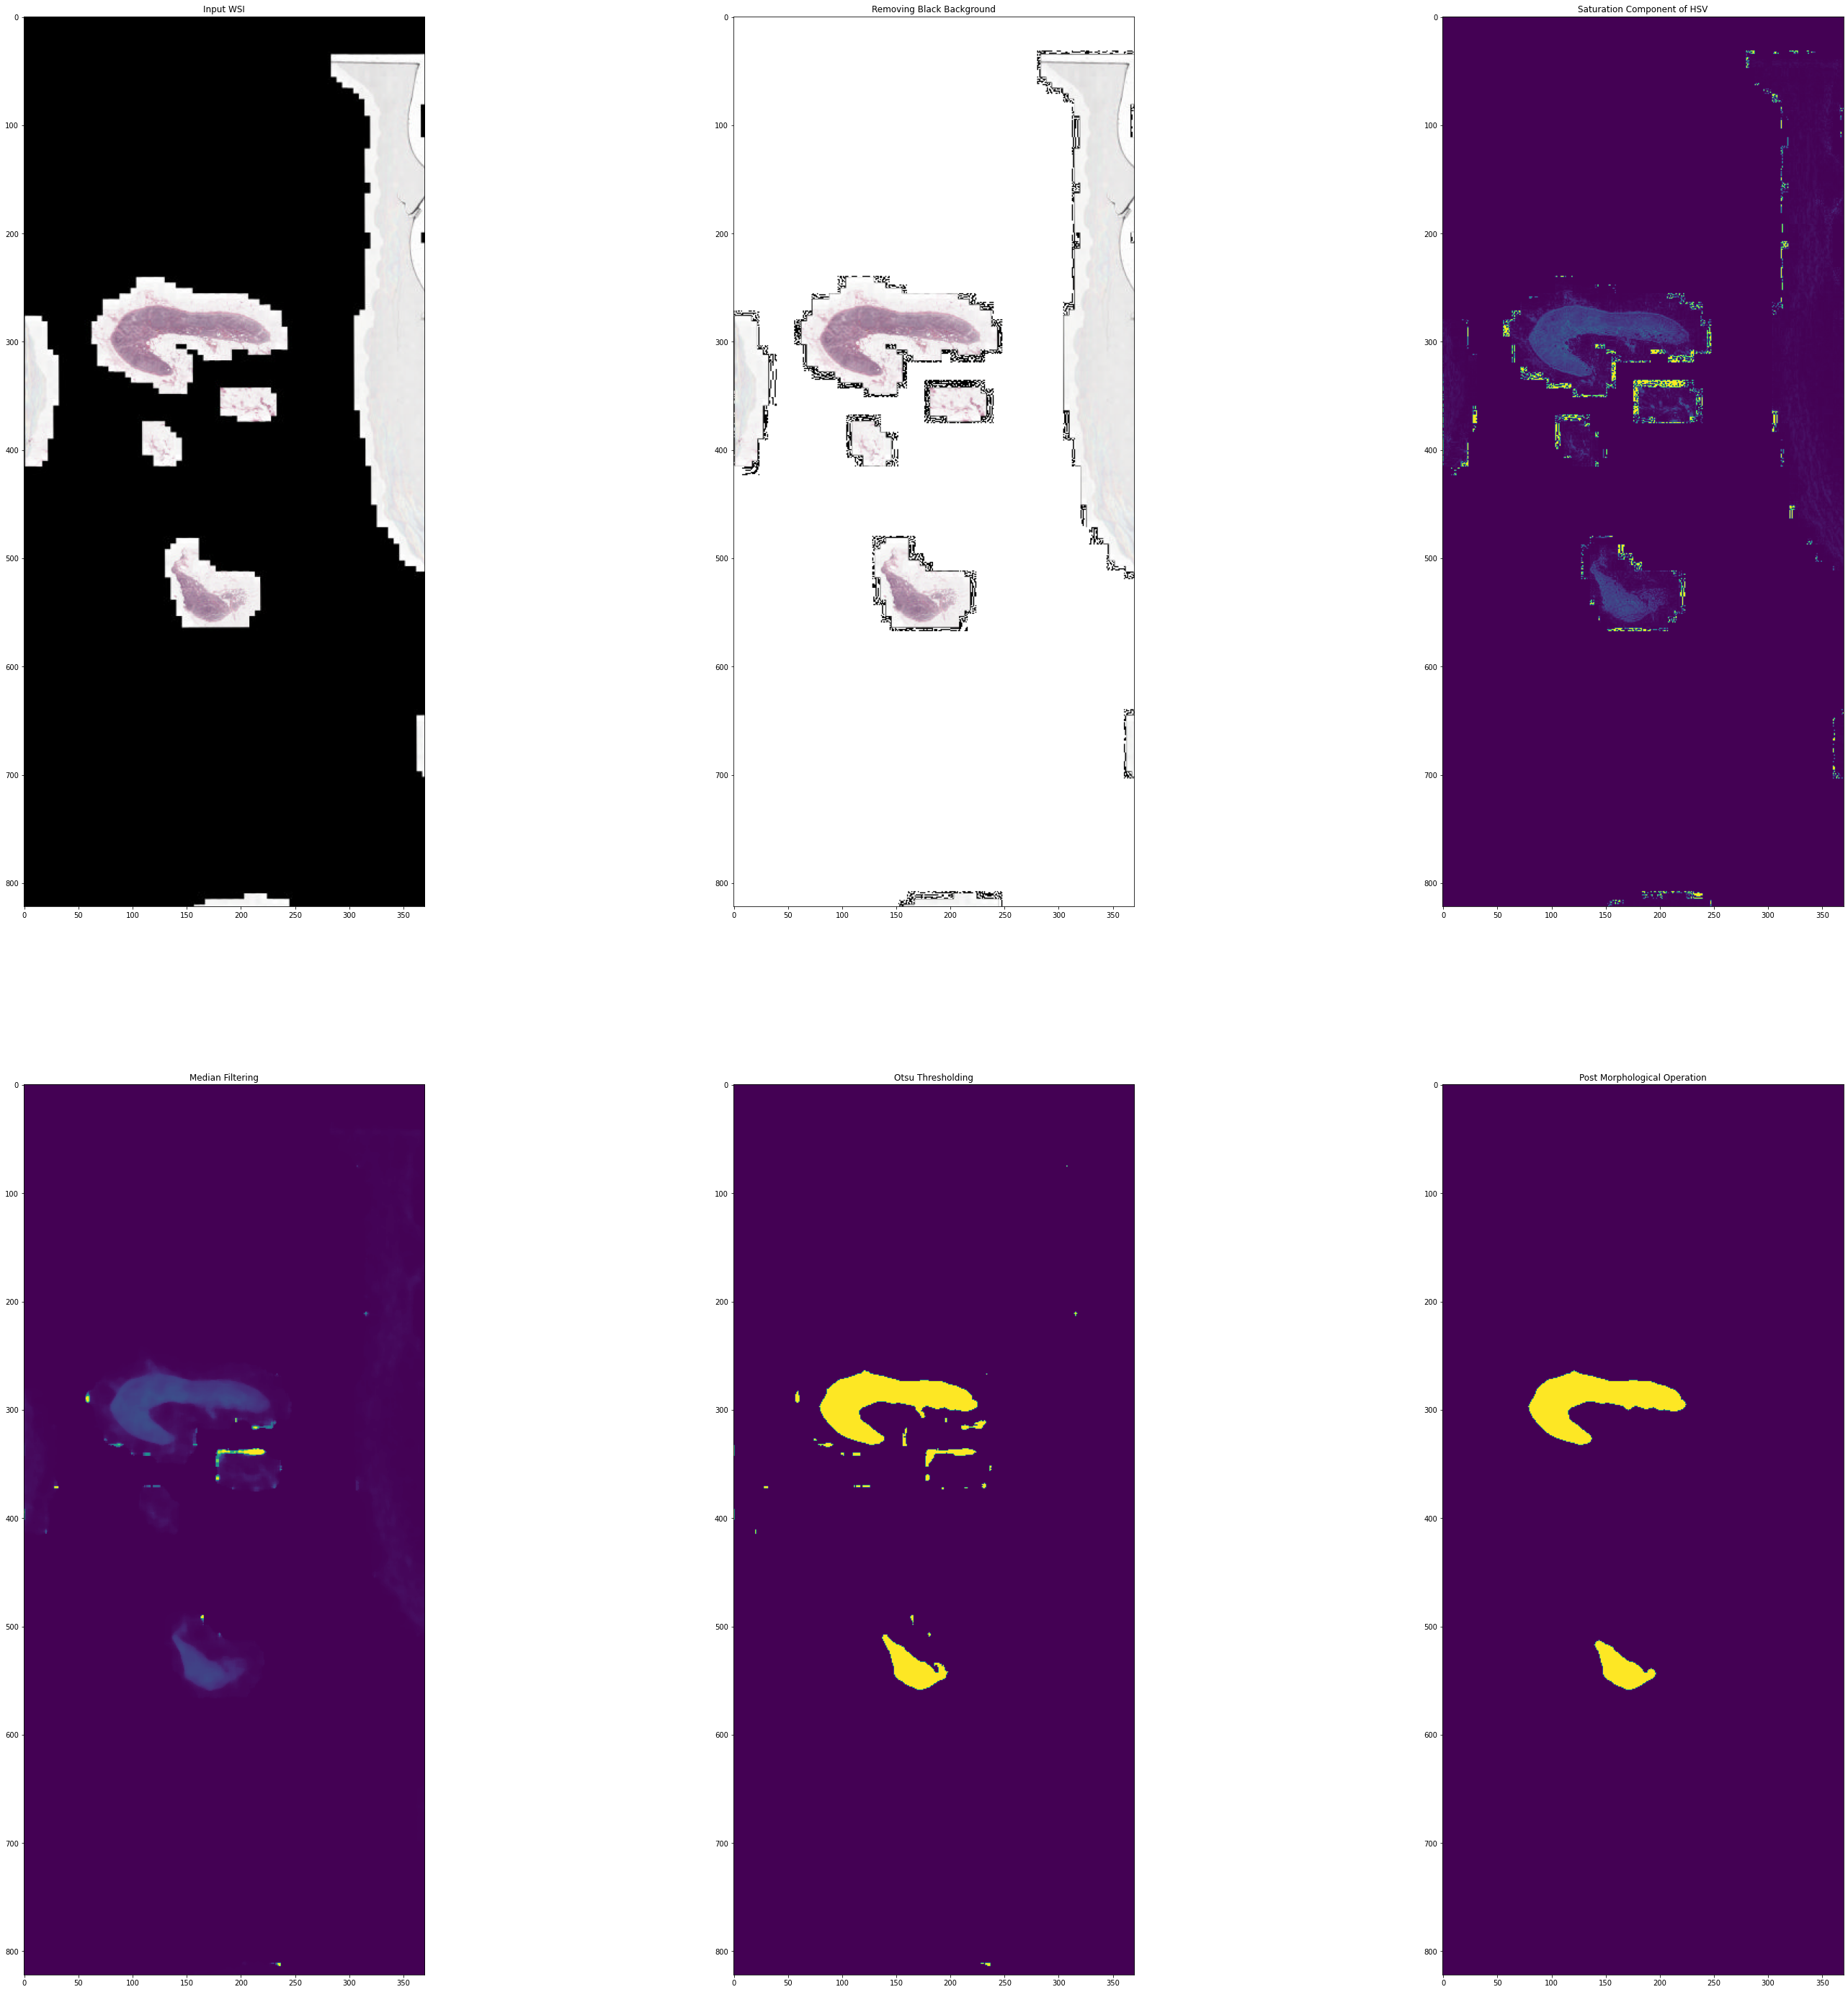

In [16]:
display_segmentation_pipeline(sample_slide, LEVEL)

## WSI Tiling

In [10]:
import csv
import h5py
from openslide.deepzoom import DeepZoomGenerator

In [11]:
# PATCH_DIR_H5 = os.path.join(BASE_DIR, "patches/h5/")
# PATCH_DIR_PNG = os.path.join(BASE_DIR, "patches/png/")
# STITCH_DIR = os.path.join(BASE_DIR, "stitches/")

PATCH_DIR_H5 = os.path.join(".", "datasets/Camelyon17/patches/h5/")
PATCH_DIR_PNG = os.path.join(".", "datasets/Camelyon17/patches/png/")
STITCH_DIR = os.path.join(".", "datasets/Camelyon17/stitches/")
PATCH_LEVEL = 12
PATCH_SIZE = 256
PIXEL_OVERLAP = 64 #overlap in patch extraction
STORAGE_OPTION = 'hdf5' #choose either one of 'hdf5' or 'disk'

In [30]:
def read_labels(label_filepath):
    """ 
    Reads the slide-level labels from the Camelyon17's stage_labels.csv file and clean it.
    
    Args:
        
    Returns:
        labelDict : dictionary of {slide_name: tumor_label} for all the slides in training folder
    """
    
    myDict = {y[0]: y[1] for y in [x.split(",") for x in open(label_filepath).read().split('\n') if x]}
    labelDict = {}

    for key, val in myDict.items():
        if '.tif' in key:
            labelDict[key] = val

    newDict = labelDict
    for key in list(labelDict):
        newDict[key.split('.')[0]] = newDict.pop(key) #remove '.tif' from keys
    
    for key, value in newDict.items():
        if value == 'negative':
            newDict[key] = 0
        if value == 'itc':
            newDict[key] = 1
        if value == 'micro':
            newDict[key] = 2
        if value == 'macro':
            newDict[key] = 3
            
    return newDict


def save_to_hdf5(file_name, patches, coords, labels, db_location=PATCH_DIR_H5):
    """ 
    Saves the numpy arrays to HDF5 files. All patches from a single WSI will be saved 
    to the same HDF5 file, regardless of the transaction size specified by rows_per_txn, 
    because this is the most efficient way to use HDF5 datasets.
    
    Args:
        - slide        :    file path to the WSI to be saved into hdf5
        - db_location  :    folder to save h5 data in
        - patches      :    list of numpy images
        - coords       :    x, y tile coordinates
        - file_name    :    original source WSI name
        - labels       :    dictionary of {slide_name: tumor_label} for all the slides in training folder
    """
    print("Saving patches in HDF5 file for {}.".format(file_name))
    
    if not os.path.exists(db_location):
        os.makedirs(db_location)
        
    # Save patches into hdf5 file.
    slide = file_name
    with h5py.File(db_location + 'training.h5','a') as hf:
        patient_index = "_".join(os.path.basename(slide).split('.')[0].split('_')[:2])
        slide_index = "_".join(os.path.basename(slide).split('.')[0].split('_')[3])
        slide_label = labels[os.path.basename(slide)]
        grp = hf.require_group(patient_index)
        subgrp = grp.require_group('wsi_{}'.format(slide_index))
#         grp = hf.create_group(patient_index)
#         subgrp = grp.create_group('wsi_{}'.format(slide_index))
        
        for i, patch in enumerate(patches):
#             patch_name = file_name + "_" + str(i) 
#             subsubgrp = subgrp.create_group('patch_{}'.format(i))
#             subsubgrp.create_dataset('image', np.shape(patch), data=patch, compression="gzip", compression_opts=7)
#             subsubgrp.create_dataset('label', np.shape(slide_label), data=slide_label)
            subsubgrp = subgrp.require_group('patch_{}'.format(i))
            subsubgrp.require_dataset('image', np.shape(patch), data=patch, dtype='uint8',  compression="gzip", compression_opts=7)
            subsubgrp.require_dataset('label', np.shape(slide_label), data=slide_label, dtype='int64')
            subsubgrp.attrs["patch_coords"] = (coords[i][0], coords[i][1])


#     Save all label meta into a csv file.
#     with open(db_location + file_name + '.csv', 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile, delimiter=' ', quotechar='|', quoting=csv.QUOTE_MINIMAL)
#         for i in range(len(labels)):
#             writer.writerow([coords[i][0], coords[i][1], labels[i]])

def save_to_disk(patches, coords, file_name, labels, db_location=PATCH_DIR_PNG):
    """ 
    Saves numpy patches to .png files (full resolution). 
    Meta data is saved in the file name.
    
    Args:
        - db_location  :    folder to save images in
        - patches      :    numpy images
        - coords       :    x, y tile coordinates
        - file_name    :    original source WSI name
        - labels       :    patch labels (opt)
    """
    print("Saving patches to disk (png).")
    
    if not os.path.exists(db_location):
        os.makedirs(db_location)
        
    save_labels = len(labels)
    for i, patch in enumerate(patches):
        patch_fname = file_name + "_" + str(coords[i][0]) + "_" + str(coords[i][1]) + "_"

        if save_labels:
            patch_fname += str(labels[i])
            
        Image.fromarray(patch).save(db_location + patch_fname + ".png")

In [14]:
def patch_to_tile_size(patch_size, overlap):
    return patch_size - overlap*2


def sample_and_store_patches(slide_path,
                             label_filepath,
                             level,
                             pixel_overlap=0,
                             patch_size=256,
                             limit_bounds=False,
                             rows_per_txn=200,
                             storage_option='hdf5'):
    """ 
    Sample patches of specified size from WSI file.
    
    Args:
        - slides          :    list of all available WSI file paths
        - file_name       :    name of whole slide image to sample from
        - file_dir        :    directory file is located in
        - pixel_overlap   :    pixels overlap on each side
        - level           :    0 is lowest resolution; level_count - 1 is highest
        - rows_per_txn    :    how many patches to load into memory at once
        - storage_option  :    the patch storage option              
        
    Note: patch_size is the dimension of the sampled patches, NOT equivalent to 
    openslide's definition of tile_size.
    
    Return:
        Count(int): #tiles extracted from the WSI
    """
    tile_size = patch_to_tile_size(patch_size, pixel_overlap)
    labels = read_labels(label_filepath)
    
    for file in slide_path:
        slide = open_slide(file)  
        tiles = DeepZoomGenerator(slide,
                                  tile_size=tile_size,
                                  overlap=pixel_overlap,
                                  limit_bounds=limit_bounds)

        if level >= tiles.level_count:
            print("[py-wsi error]: requested level does not exist. Number of slide levels: " 
                  + str(tiles.level_count))
            return 0

        x_tiles, y_tiles = tiles.level_tiles[level]
        print("x_tiles, y_tiles: ", x_tiles, y_tiles)
        print("level count: ", slide.level_count)

        x, y = 0, 0
        count, batch_count = 0, 0
        patches, coords = [], []
        while y < y_tiles:
            while x < x_tiles:
                new_tile = np.array(tiles.get_tile(level, (x, y)), dtype=np.uint8)
                # OpenSlide calculates overlap in such a way that sometimes depending on the 
                # dimensions, edge patches are smaller than the others. We will ignore such patches.
                if np.shape(new_tile) == (patch_size, patch_size, 3):
                    patches.append(new_tile)
                    coords.append(np.array([x, y]))
                    count += 1

                x += 1

            # To save memory, we will save data into the dbs every rows_per_txn rows. i.e., 
            # each transaction will commit #rows_per_txn rows of patches. Write after last row 
            # regardless. HDF5 does NOT follow this convention due to efficiency.
            if (y % rows_per_txn == 0 and y != 0) or y == y_tiles-1:
                if storage_option == 'disk':
                    file_name = os.path.basename(slide_path).rsplit('.')[0]
                    save_to_disk(patches, coords, file_name, labels)
                if storage_option != 'hdf5':
                    del patches
                    del coords
                    patches, coords = [], [] # Reset right away.

            y += 1
            x = 0

        if storage_option == 'hdf5':
            file_name = os.path.basename(file).split('.')[0]
            save_to_hdf5(file_name, patches, coords, labels)

    return count

In [34]:
# label_filepath = os.path.join(BASE_DIR , 'training/stage_labels.csv')
label_filepath = "./datasets/Camelyon17/training/stage_labels.csv"

slide_path = glob.glob("./datasets/Camelyon17/training/center_4/patient_*.tif")
print("Number of slides to ", len(slide_path))

sample_and_store_patches(slide_path,
                         label_filepath,
                         level=PATCH_LEVEL,
                         pixel_overlap=PIXEL_OVERLAP,
                         patch_size=PATCH_SIZE,
                         limit_bounds=True,
                         rows_per_txn=200,
                         storage_option=STORAGE_OPTION)

Number of slides to  2
x_tiles, y_tiles:  25 12
level count:  10
Saving patches in HDF5 file for patient_080_node_0.
x_tiles, y_tiles:  21 11
level count:  10
Saving patches in HDF5 file for patient_080_node_1.


162

## HDF testing

In [18]:
# !pip install h5glance
from h5glance import H5Glance

In [32]:
read_h5 = h5py.File('./datasets/Camelyon17/patches/h5/training.h5', 'r+')
H5Glance(read_h5)

In [22]:
read_h5.close()

### testing seg

In [133]:
im = Image.open('segmented_img.png')
im.save("segmented_slide.tiff", 'TIFF')

In [134]:
sample_slide_1 = "segmented_slide.tiff"


In [135]:
get_slide_info(sample_slide_1)

Level count:         1
Level dimensions:    ((4320, 4320),)


In [139]:
slide = open_slide(sample_slide_1)  
tiles = DeepZoomGenerator(slide,
                          tile_size=256,
                          overlap=0)

In [ ]:
sample_and_store_patches(slide_path = open_slide(sample_slide_1),
                         level=0,
                         pixel_overlap=PIXEL_OVERLAP,
                         patch_size=PATCH_SIZE,
                         limit_bounds=True,
                         rows_per_txn=200,
                         storage_option=STORAGE_OPTION)

In [161]:
tile_size = 256
level = 13
patch_size = 256
rows_per_txn = 200
storage_option = 'hdf5'

slide = open_slide(sample_slide_1)  
tiles = DeepZoomGenerator(slide,
                          tile_size=256,
                          overlap=64)

if level >= tiles.level_count:
    print("[py-wsi error]: requested level does not exist. Number of slide levels: " 
          + str(tiles.level_count))

x_tiles, y_tiles = tiles.level_tiles[level]
print("x_tiles, y_tiles: ", x_tiles, y_tiles)
print("level count: ", slide.level_count)

x, y = 0, 0
count, batch_count = 0, 0
patches, coords = [], []
while y < y_tiles:
    while x < x_tiles:
        new_tile = np.array(tiles.get_tile(level, (x, y)), dtype=np.uint8)
        if np.shape(new_tile) == (patch_size, patch_size, 3):
            patches.append(new_tile)
            coords.append(np.array([x, y]))
            count += 1

        x += 1

    if (y % rows_per_txn == 0 and y != 0) or y == y_tiles-1:
        if storage_option == 'disk':
            file_name = os.path.basename(slide_path).rsplit('.')[0]
            save_to_disk(patches, coords, file_name, labels)
        if storage_option != 'hdf5':
            del patches
            del coords
            patches, coords = [], []

    y += 1
    x = 0

# if storage_option == 'hdf5':
#     file_name = os.path.basename(sample_slide_1).split('.')[0]
#     save_to_hdf5(file_name, patches, coords, labels)
    
slide = sample_slide_1 #file_name
with h5py.File('sample.h5','a') as hf:
    patient_index = '001'
    slide_index = '002'
    slide_label = 'label_0'

    grp = hf.require_group(patient_index)
    subgrp = grp.require_group('wsi_{}'.format(slide_index))

    for i, patch in enumerate(patches):
        subsubgrp = subgrp.require_group('patch_{}'.format(i))
        subsubgrp.create_dataset('image', np.shape(patch), data=patch, compression="gzip", compression_opts=7)
        subsubgrp.create_dataset('label', np.shape(slide_label), data=slide_label)
        subsubgrp.attrs["patch_coords"] = (coords[i][0], coords[i][1])


x_tiles, y_tiles:  17 17
level count:  1


In [162]:
read_h5 = h5py.File('sample.h5', 'r')
H5Glance(read_h5)

## patch extraction test

In [175]:
def extract_grayscale_patches( img, shape, offset=(0,0), stride=(1,1) ):
    """Extracts (typically) overlapping regular patches from a grayscale image

    Changing the offset and stride parameters will result in images
    reconstructed by reconstruct_from_grayscale_patches having different
    dimensions! Callers should pad and unpad as necessary!

    Args:
        img (HxW ndarray): input image from which to extract patches

        shape (2-element arraylike): shape of that patches as (h,w)

        offset (2-element arraylike): offset of the initial point as (y,x)

        stride (2-element arraylike): vertical and horizontal strides

    Returns:
        patches (ndarray): output image patches as (N,shape[0],shape[1]) array

        origin (2-tuple): array of top and array of left coordinates
    """
    px, py = np.meshgrid( np.arange(shape[1]),np.arange(shape[0]))
    l, t = np.meshgrid(np.arange(offset[1], img.shape[1]-shape[1]+1, stride[1]),
                       np.arange(offset[0], img.shape[0]-shape[0]+1, stride[0])
                      )
    l = l.ravel()
    t = t.ravel()
    x = np.tile( px[None,:,:], (t.size,1,1)) + np.tile( l[:,None,None], (1,shape[0],shape[1]))
    y = np.tile( py[None,:,:], (t.size,1,1)) + np.tile( t[:,None,None], (1,shape[0],shape[1]))
    for i in range(img.shape[3]):
        img[:, :, i] = img[y.ravel(), x.ravel(), i].reshape((t.size, shape[0], shape[1]))
        
    return img[y.ravel(), x.ravel()].reshape((t.size, shape[0], shape[1])), (t,l)


def reconstruct_from_grayscale_patches( patches, origin, epsilon=1e-12 ):
    """Rebuild an image from a set of patches by averaging

    The reconstructed image will have different dimensions than the
    original image if the strides and offsets of the patches were changed
    from the defaults!

    Args:
        patches (ndarray): input patches as (N,patch_height,patch_width) array

        origin (2-tuple): top and left coordinates of each patch

        epsilon (scalar): regularization term for averaging when patches
            some image pixels are not covered by any patch

    Returns:
        image (ndarray): output image reconstructed from patches of
            size ( max(origin[0])+patches.shape[1], max(origin[1])+patches.shape[2])

        weight (ndarray): output weight matrix consisting of the count
            of patches covering each pixel
    """
    patch_width  = patches.shape[2]
    patch_height = patches.shape[1]
    img_width    = np.max( origin[1] ) + patch_width
    img_height   = np.max( origin[0] ) + patch_height

    out = np.zeros( (img_height,img_width) )
    wgt = np.zeros( (img_height,img_width) )
    for i in range(patch_height):
        for j in range(patch_width):
            out[origin[0]+i, origin[1]+j] += patches[:,i,j]
            wgt[origin[0]+i, origin[1]+j] += 1.0

    return out/np.maximum( wgt, epsilon ), wgt

In [164]:
import time

(4320, 4320)
p.shape:  (4096, 256, 256)
origin[0].shape, origin[1].shape:  (4096,) (4096,)
Patch extraction took: 5.3s
Image reconstruction took: 17.51s
Reconstruction error is: 0.0


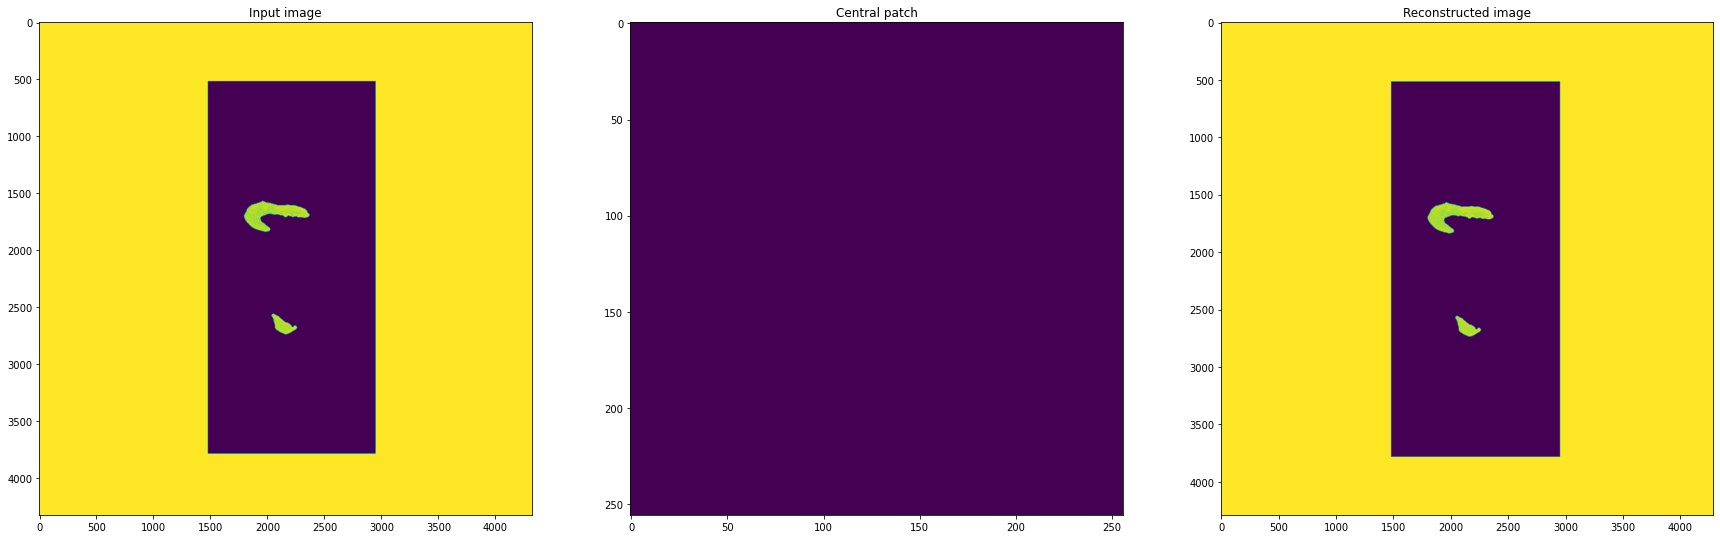

In [206]:
img_orig = cv2.imread('segmented_img.png')[:,:,::-1]
# img_orig1 = cv2.imread('segmented_img.png')[:,:,:]
img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)

# print('img_orig1.shape: ', img_orig1.shape)
print('img_orig.shape: ', img_orig.shape)
# print('img.shape: ', img.shape)

# plt.figure(figsize = (30,20))
# plt.imshow( cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB) )

print(img[:,:].shape)
start = time.time()
p, origin = extract_grayscale_patches( img, (256, 256), stride=(64, 64) )
print("p.shape: ", p.shape)
print("origin[0].shape, origin[1].shape: ", origin[0].shape, origin[1].shape)
end = time.time()
print( 'Patch extraction took: {}s'.format(np.round(end-start,2)) )
start = time.time()
r, w = reconstruct_from_grayscale_patches( p, origin )
end = time.time()
print('Image reconstruction took: {}s'.format(np.round(end-start,2)) )
print( 'Reconstruction error is: {}'.format( np.linalg.norm( img[:r.shape[0],:r.shape[1]]-r ) ) )

plt.figure(figsize = (30,20))
plt.subplot( 131 )
plt.imshow( img[:,:] )
plt.title('Input image')
plt.subplot( 132 )
plt.imshow( p[p.shape[0]//2] )
plt.title('Central patch')
plt.subplot( 133 )
plt.imshow( r )
plt.title('Reconstructed image')
# plt.savefig('receonstructed.png')
plt.show()

In [ ]:
img_orig.shape

## Patch extraction -3

In [17]:
import sys, re

In [18]:
class ProgressBar(object):
    DEFAULT = 'Progress: %(bar)s %(percent)3d%%'
    FULL = '%(bar)s %(current)d/%(total)d (%(percent)3d%%) %(remaining)d to go'

    def __init__(self, total, width=40, fmt=DEFAULT, symbol='=',
                 output=sys.stderr):
        assert len(symbol) == 1

        self.total = total
        self.width = width
        self.symbol = symbol
        self.output = output
        self.fmt = re.sub(r'(?P<name>%\(.+?\))d',
            r'\g<name>%dd' % len(str(total)), fmt)

        self.current = 0

    def __call__(self):
        percent = self.current / float(self.total)
        size = int(self.width * percent)
        remaining = self.total - self.current
        bar = '[' + self.symbol * size + ' ' * (self.width - size) + ']'

        args = {
            'total': self.total,
            'bar': bar,
            'current': self.current,
            'percent': percent * 100,
            'remaining': remaining
        }
        print('\r' + self.fmt % args, file=self.output, end='')

    def done(self):
        self.current = self.total
        self()
        print('', file=self.output)

In [25]:
slides = glob.glob(BASE_DIR + 'training/center_*/patient_*.tif')
sample_slide = slides[0]
level_count, level_dimensions = get_slide_info(sample_slide)
level = 5
slide_obj = open_slide(sample_slide)
image = read_slide(slide_obj, 
                   (0,0), 
                   level, 
                   (slide_obj.level_dimensions[level][0], 
                    slide_obj.level_dimensions[level][1]))

mask = segment_tissue_from_background(sample_slide, level)
img_segmented = overlay_img_and_segmentation_mask(image, mask)
print("Done segmenting image.")

img = img_segmented
patches = []
patch_size = 256
overlap = 64
flattened_img = np.sum(img, axis=-1)
possible_patch_centers = np.where(flattened_img, True, False)
initial_len = np.sum(possible_patch_centers)

def get_patch_dim(center, patch_size):
    up_obj, up_lim = np.expand_dims(center+patch_size//2,0), np.expand_dims(np.array(img.shape[:2]),0)
    low_obj, low_lim = np.expand_dims(center-patch_size//2,0), np.zeros((1,2))
    upper_bound = np.min(np.concatenate([up_obj, up_lim]), axis=0)
    upper_extra = np.max(np.concatenate([up_obj - up_lim, np.zeros((1,2))]), axis=0)
    lower_bound = np.max(np.concatenate([low_obj, low_lim]), axis=0) 
    lower_extra = -np.min(np.concatenate([low_obj, low_lim]), axis=0)
    patch_dim = [int(lower_bound[0]-upper_extra[0]), int(upper_bound[0]+lower_extra[0]),
                 int(lower_bound[1]-upper_extra[1]), int(upper_bound[1]+lower_extra[1])]
    return patch_dim

condition = np.any(possible_patch_centers)
progress = ProgressBar(100, fmt=ProgressBar.FULL)
while condition==True:
    non_black_indexes = np.argwhere(possible_patch_centers)
    milestone = np.sum(possible_patch_centers)/initial_len*100
    idx = non_black_indexes[0]

    # Extract the patch
    patch_dim = get_patch_dim(idx, patch_size)
    patches.append(img[patch_dim[0]:patch_dim[1], patch_dim[2]:patch_dim[3]])

    # Remove indexes in the range of overlap for possible next centers
    overlap_dim = get_patch_dim(idx, patch_size-overlap+patch_size//2)
    possible_patch_centers[overlap_dim[0]:overlap_dim[1], overlap_dim[2]:overlap_dim[3]] = 0

    # Update progress bar
    progress.current = 100 - milestone
    progress()

    condition = np.any(possible_patch_centers)

progress.done()

Level count:         9
Level dimensions:    ((94968, 210579), (47484, 105289), (23742, 52644), (11871, 26322), (5935, 13161), (2967, 6580), (1483, 3290), (741, 1645), (370, 822))
Done segmenting image.


[========================================] 100/100 (100%)   0 to go
